# Pre processing the data

## Reading the data and setting imports


In [37]:
import pandas as pd
import numpy as np
import re
import nltk
import torch

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from textblob import TextBlob

# Baixar recursos necessários
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


df_raw = pd.read_csv('../data/raw/full_data_2021_FORD.csv')
df_raw.head(1)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Year,Make,Model,odiNumber,manufacturer,crash,fire,numberOfInjuries,numberOfDeaths,dateOfIncident,dateComplaintFiled,vin,components,summary,products
0,2021,FORD,F-350 REGULAR CAB,11639053,Ford Motor Company,False,False,0,0,12/31/2024,01/28/2025,1FT8W3BT2ME,"FUEL SYSTEM, DIESEL",The contact owns a 2021 Ford F-350. The contac...,"[{'type': 'Vehicle', 'productYear': '2021', 'p..."


## Initial steps to process the data

In [38]:
# Removing unnecessary columns
df_final = df_raw.drop(['Make','odiNumber', 'manufacturer', 'vin', 'products'], axis=1)

In [39]:
# Changing the type of bool to int

df_final['fire'] = df_final['fire'].astype(int)
df_final['crash'] = df_final['crash'].astype(int)

In [40]:
# Converting the 'dateOfIncident' and 'dateComplaintFiled' columns to datetime format
df_final['dateOfIncident'] = pd.to_datetime(df_final['dateOfIncident'])
df_final['dateComplaintFiled'] = pd.to_datetime(df_final['dateComplaintFiled'])

# Creating a new feature that could be valuable for the model: the difference in days between the incident date and the complaint filed date
df_final['daysBetween'] = (df_final['dateComplaintFiled'] - df_final['dateOfIncident']).dt.days


In [41]:
# Splitting the 'components' column into a list of components for each row, handling missing values
df_final["components_list"] = df_final["components"].apply(lambda x: x.split(",") if pd.notna(x) else [])


## Text Processing Section

In [42]:
# Text preprocessing function

def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    
    text = text.lower()
    
    # Tokenization: Split the text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords (common words like 'the', 'and', etc.)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization: Convert words to their base or root form (e.g., 'running' to 'run')
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)  

df_final['processed_summary'] = df_final['summary'].apply(preprocess_text)

In these case i decided to use bert because its a more robust model that generates contextual embeddings.

This is important for analyzing complaints, as it helps capture the full meaning of the text and identify patterns or issues more accurately

In [43]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_model_embedding(text):
    """Converts text into a BERT embedding"""
    if pd.isna(text):
        return torch.zeros(768)  
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df_final['summary_embedding'] = df_final['summary'].apply(get_model_embedding)
df_final['model_embedding'] = df_final['Model'].apply(get_model_embedding)


In [44]:
# Calculating the word count and character count for the processed summary
df_final["word_count"] = df_final["processed_summary"].apply(lambda x: len(x.split()))  # Count the number of words
df_final["char_count"] = df_final["processed_summary"].apply(len)  # Count the number of characters

In [45]:
df_final['summary_embedding'] = df_final['summary_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
df_final['model_embedding'] = df_final['model_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)

In [46]:
# Calculating the sentiment polarity for each processed summary
df_final['sentiment'] = df_final['processed_summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

# 1.0 → Positive, 0.0 → Neutral, -1.0 → Negative

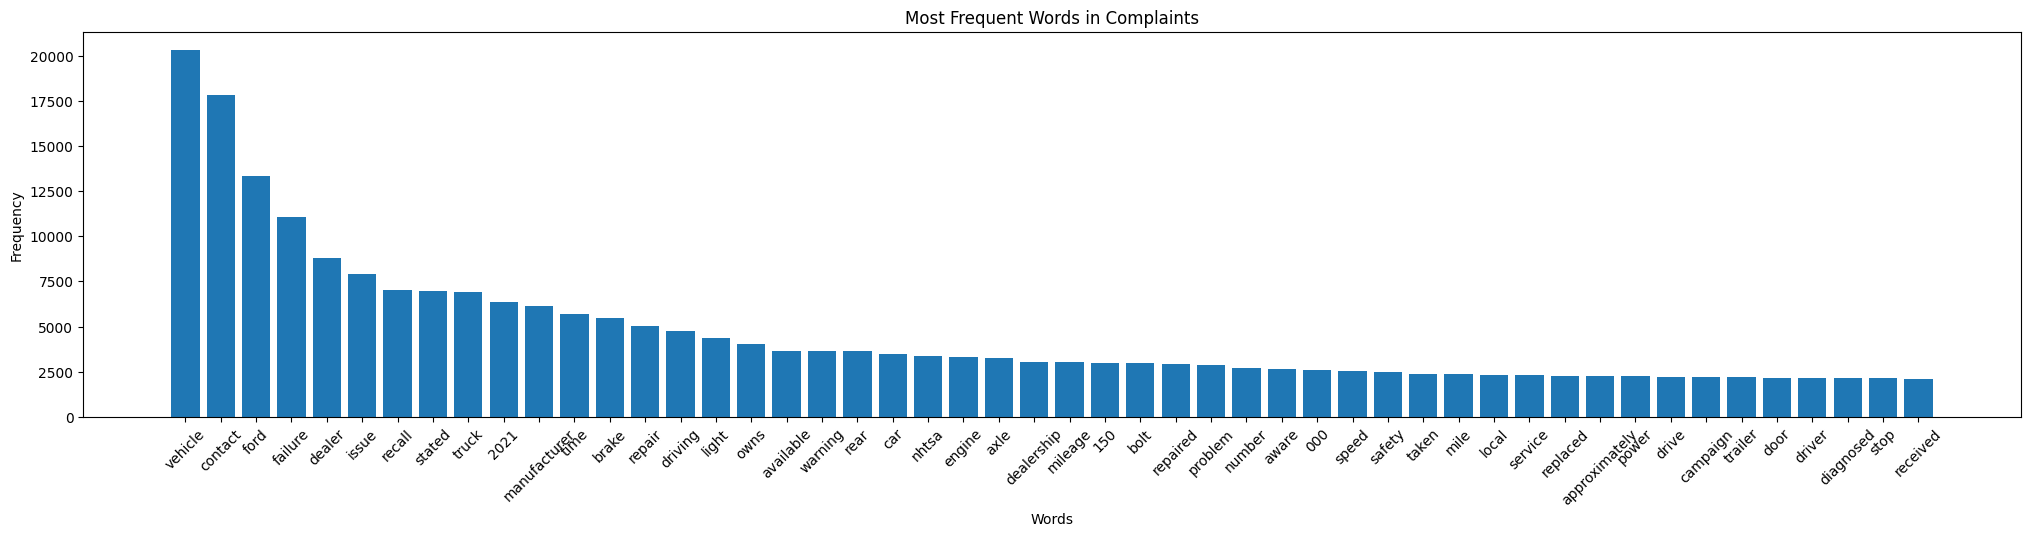

Most Frequent Words in Complaints:
vehicle: 20303
contact: 17825
ford: 13360
failure: 11069
dealer: 8785
issue: 7900
recall: 7005
stated: 6982
truck: 6888
2021: 6377
manufacturer: 6124
time: 5674
brake: 5464
repair: 5027
driving: 4761
light: 4366
owns: 4053
available: 3669
rear: 3638
car: 3455
nhtsa: 3381
engine: 3307
axle: 3265
dealership: 3063
mileage: 3033
150: 2983
bolt: 2975
repaired: 2912
problem: 2898
number: 2695
aware: 2666
000: 2598
speed: 2565
safety: 2497
taken: 2373
mile: 2358
local: 2297
service: 2296
replaced: 2284
approximately: 2279
power: 2246
drive: 2231
campaign: 2219
trailer: 2206
door: 2158
driver: 2141
diagnosed: 2136
stop: 2133
received: 2078


In [47]:
texts = df_final['processed_summary'].dropna()  

# Analyzing the most frequent words using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=50)  # Remove common stopwords and limit to top 50 words
word_counts = vectorizer.fit_transform(texts)  # Transform the text into a matrix of word counts

# Get the most frequent words
words_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1))
sorted_words_freq = sorted(words_freq.items(), key=lambda x: x[1], reverse=True)  # Sort words by frequency

# Visualize the most frequent words with a bar chart
plt.figure(figsize=(25, 5))  
plt.bar(*zip(*sorted_words_freq))  
plt.xticks(rotation=45)  
plt.title('Most Frequent Words in Complaints')  
plt.xlabel('Words')  
plt.ylabel('Frequency')  
plt.show()  

# Display the most frequent words in the console
print("Most Frequent Words in Complaints:")
for word, freq in sorted_words_freq:
    print(f"{word}: {freq}")


The word "recall" appears 6,635 times, suggesting that many complaints are related to safety issues that could result in a recall.

Terms such as "failure" (10,606), "issue" (6,746), "problem" (2,573), and "safety" (2,496) also indicate a strong emphasis on critical technical issues.

Terms like "nhtsa" (3,330) indicate that consumers frequently mention the National Highway Traffic Safety Administration (NHTSA) in their complaints, possibly to report serious failures.

## Components Processing Section

I decided to create a model that can predict the type of problem based solely on the text of vehicle complaints. 

This will help Ford efficiently classify and prioritize issues reported by customers, enabling faster identification of critical components affected, such as safety-related systems or engine performance.

It will help the company identify the major problem with the car without requiring extensive manual review, allowing quicker response times for addressing common defects.

In [48]:
# Analyzing the distribution of data in the 'components
df_final['components_list'].explode().value_counts()

components_list
POWER TRAIN                           3651
ELECTRICAL SYSTEM                     2084
UNKNOWN OR OTHER                      1534
ENGINE                                1425
SERVICE BRAKES                        1301
VISIBILITY                            1107
STRUCTURE                              907
VISIBILITY/WIPER                       760
FORWARD COLLISION AVOIDANCE            676
WHEELS                                 589
EXTERIOR LIGHTING                      524
STEERING                               453
SUSPENSION                             431
FUEL/PROPULSION SYSTEM                 420
BACK OVER PREVENTION                   410
VEHICLE SPEED CONTROL                  347
ENGINE AND ENGINE COOLING              316
LANE DEPARTURE                         216
 HYDRAULIC                             206
EQUIPMENT                              206
FUEL SYSTEM                            159
LATCHES/LOCKS/LINKAGES                 151
SEAT BELTS                            

In [49]:
# Mapping the problemns 
category_map = {
    'ENGINE': 'Engine and Performance',
    'POWER TRAIN': 'Engine and Performance',
    'FUEL SYSTEM': 'Engine and Performance',
    'ENGINE AND ENGINE COOLING': 'Engine and Performance',
    'HYBRID PROPULSION SYSTEM': 'Engine and Performance',
    
    'AIR BAGS': 'Safety and Brakes',
    'SEAT BELTS': 'Safety and Brakes',
    'SERVICE BRAKES': 'Safety and Brakes',
    'LATCHES/LOCKS/LINKAGES': 'Safety and Brakes',
    'PARKING BRAKE': 'Safety and Brakes',

    'ELECTRICAL SYSTEM': 'Electrical System',
    'ELECTRONIC STABILITY CONTROL (ESC)': 'Electrical System',
    'EXTERIOR LIGHTING': 'Electrical System',
    'VISIBILITY': 'Electrical System',
    'VISIBILITY/WIPER': 'Electrical System',

    'STRUCTURE': 'Structure and Control',
    'STEERING': 'Structure and Control',
    'WHEELS': 'Structure and Control',
    'SUSPENSION': 'Structure and Control',
    'VEHICLE SPEED CONTROL': 'Structure and Control',
    'LANE DEPARTURE': 'Structure and Control',

    'UNKNOWN OR OTHER': 'Other Problems',
    'BACK OVER PREVENTION': 'Other Problems',
    'TRAILER HITCHES': 'Other Problems',
    'COMMUNICATION': 'Other Problems'
}

# Creating category column without duplicates 
df_final["general_category"] = df_final["components_list"].apply(
    lambda x: list(set(category_map.get(i, "Other Problems") for i in x))
)


general_category
Engine and Performance    5168
Electrical System         4262
Other Problems            3489
Structure and Control     2760
Safety and Brakes         1708
Name: count, dtype: int64


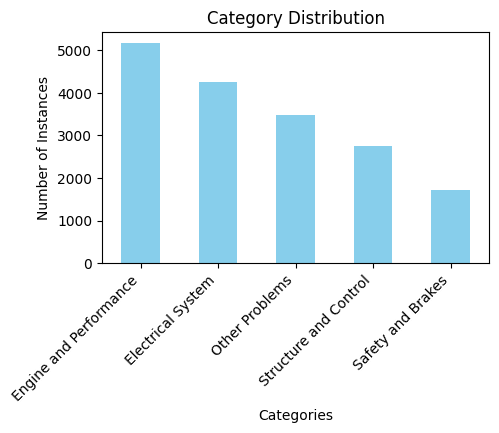

In [ ]:
# Here we are plotting the distribution of categories
# Calculate category counts
category_counts = df_final["general_category"].explode().value_counts()

# Display category counts
print(category_counts)

# Plot the distribution
plt.figure(figsize=(5, 3))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.show()


As we can see in the graph above, we have some categories with more data than others.

As we want the model to reflect the operational reality of the most common problems faced we will not apply data balancing.

The model will be evaluated in terms of F1-score, recall and precision and if it significantly favors larger categories we will apply data balancing.

In [51]:
# Checking the mapping 
df_final[['general_category','components_list']].head()

,general_category,components_list
0,"[Engine and Performance, Other Problems]","[FUEL SYSTEM, DIESEL]"
1,"[Engine and Performance, Electrical System]","[POWER TRAIN, ELECTRICAL SYSTEM]"
2,"[Engine and Performance, Other Problems]","[FUEL SYSTEM, DIESEL]"
3,"[Engine and Performance, Other Problems, Safet...","[SUSPENSION, FUEL SYSTEM, DIESEL, SERVICE BRA..."
4,"[Engine and Performance, Other Problems]","[FUEL SYSTEM, DIESEL]"


### Creating the Multi Label Target 

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer

df_final['category_binary'] = ''

mlb = MultiLabelBinarizer()

# Apply the fit_transform method to the 'general_category' column.
# transforming  each category into a binary matrix
y = mlb.fit_transform(list(df_final['general_category']))

df_final['category_binary'] = list(y)

# Example of how the classes look after transformation:
print(mlb.classes_)  
print(y[:5])  


['Electrical System' 'Engine and Performance' 'Other Problems'
 'Safety and Brakes' 'Structure and Control']
[[0 1 1 0 0]
 [1 1 0 0 0]
 [0 1 1 0 0]
 [0 1 1 1 1]
 [0 1 1 0 0]]


In [53]:
# Checking the MultiLabelBinarizer Mapping 

df_final[['general_category','category_binary']].head()

,general_category,category_binary
0,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]"
1,"[Engine and Performance, Electrical System]","[1, 1, 0, 0, 0]"
2,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]"
3,"[Engine and Performance, Other Problems, Safet...","[0, 1, 1, 1, 1]"
4,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]"


## Saving My Processed Data

In [54]:
# Checking my final columns

df_final.columns

Index(['Year', 'Model', 'crash', 'fire', 'numberOfInjuries', 'numberOfDeaths',
       'dateOfIncident', 'dateComplaintFiled', 'components', 'summary',
       'daysBetween', 'components_list', 'processed_summary',
       'summary_embedding', 'model_embedding', 'word_count', 'char_count',
       'sentiment', 'general_category', 'category_binary'],
      dtype='object')

In [55]:
# Converta as colunas de embeddings (ndarray) para listas antes de salvar como JSON
df_final['summary_embedding'] = df_final['summary_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
df_final['model_embedding'] = df_final['model_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
df_final['category_binary'] = df_final['category_binary'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)

In [56]:
# Checking my final df

df_final.head(2)

,Year,Model,crash,fire,numberOfInjuries,numberOfDeaths,dateOfIncident,dateComplaintFiled,components,summary,daysBetween,components_list,processed_summary,summary_embedding,model_embedding,word_count,char_count,sentiment,general_category,category_binary
0,2021,F-350 REGULAR CAB,0,0,0,0,2024-12-31,2025-01-28,"FUEL SYSTEM, DIESEL",The contact owns a 2021 Ford F-350. The contac...,28,"[FUEL SYSTEM, DIESEL]",contact owns 2021 ford f 350 contact received ...,"[-0.5503813028335571, -0.2038578987121582, 0.2...","[0.040037598460912704, -0.27900347113609314, -...",77,565,-0.009091,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]"
1,2021,F-350 REGULAR CAB,0,0,0,0,2024-12-29,2025-01-19,"POWER TRAIN,ELECTRICAL SYSTEM",Ford knew there was an issue back in 2021 as t...,21,"[POWER TRAIN, ELECTRICAL SYSTEM]",ford knew issue back 2021 filed agency yet wai...,"[-0.12588243186473846, 0.09368353337049484, 0....","[0.040037598460912704, -0.27900347113609314, -...",80,518,0.091667,"[Engine and Performance, Electrical System]","[1, 1, 0, 0, 0]"


In [65]:
models = df_final['Model'].unique().tolist()


# Define mean and scale values
model_data = {
    "models":models
}
# Save to JSON file
with open('../models/models_params.json', 'w') as f:
    json.dump(model_data, f)


In [57]:
# Saving my final data to use in the model
df_final[['processed_summary', 'summary_embedding', 'model_embedding', 'word_count', 'char_count',
          'sentiment', 'category_binary']].to_csv('../data/processed/df_final_model.csv',index=False)

In [59]:
# Saving my final data to use in analysis
df_final[['Year','Model', 'crash', 'fire', 'numberOfInjuries', 'numberOfDeaths',
       'dateOfIncident', 'dateComplaintFiled', 'summary',
       'daysBetween', 'components_list','sentiment',
       'general_category', 'word_count',
       'char_count']].to_csv('../data/processed/df_final_chart.csv',index=False)